In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import animation
plt.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\Erin\\AppData\\Local\\Programs\\Python\\Python36\\Lib\\site-packages\\matplotlib\\bin\\ffmpeg.exe'
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

Want to prove that <br><br><center>$X \rightarrow Y \rightarrow Z$</center><br> where X is Movement in HK(<strong>MVT</strong>) + <strong>GDP</strong> + <strong>MVT * GDP</strong>, <br>
Y is Number of Visitor Arrivals from Mainland China(<strong>NVA</strong>),<br> Z is REIT Regal's monthly closing price(<strong>Regal</strong>).<br>

# Introduction
Use 2SLS to get $\hat{Y}$ from $X_1,X_2,X_3$ and then use $\hat{Y}$ to regress $Z$.

In [2]:
def correlation_matrix(df,fontsz):
    height=13
    fig,ax = plt.subplots()
    figrs=plt.imshow(df.corr(), interpolation="nearest", cmap='coolwarm')
    plt.title('Feature Correlation')
    labels=df.columns.tolist()
    xticks = labels
    yticks = labels
    ax.set_xticks(range(len(xticks)))
    ax.set_yticks(range(len(yticks)))
    plt.xticks(fontsize=fontsz)
    plt.yticks(fontsize=fontsz)
    ax.set_xticklabels(xticks)
    ax.set_yticklabels(yticks)
    fig.colorbar(figrs, ticks=[-.5,-.4,-.3,-.2,-.1,0,.25,.5,.75,.8,.85,.90,.95,1])
    fig.set_figheight(height)
    fig.set_figwidth(height)
    print(df.corr())
    plt.show()

In [3]:
def compare_trend(df,x,y1,y2,mvt):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(df[x],df[y1],color='b',label=y1, alpha=0.5)   

    ax2 = ax1.twinx()
    ax2.plot(df[x],df[y2],color='r',label=y2, alpha=0.5)

    ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),
              df[mvt].values[np.newaxis],
              cmap='RdYlGn_r', alpha=0.28)
    
    ticks = ax1.get_xticks()
    labels = ax1.get_xticklabels()
    n = len(ticks)//15
    ax1.set_xticks(ticks[::n])
    fig.legend()
    plt.title("The shades denote Movement")
    fig.set_figheight(6)
    fig.set_figwidth(15)
    fig.show()

In [4]:
def SliceYear(df,year):
    return df.loc[(df["Year"] == year)]

In [5]:
def PlotSeasonality(start_yr,y):
    plt.figure(figsize=(16, 7))
    for year in range(start_yr,2020): 
        df_yr=SliceYear(df,year)
        i=year-start_yr
        plt.plot(df_yr.Month, df_yr[y],color=(1-i/(2020-start_yr), 0.6, 0.6),label=year)
    plt.legend(loc=0,ncol=len(df.columns))
    plt.ylabel(y)
    plt.title(y)
    plt.show()

In [6]:
def PlotXYZ(model,X,Y,angle):
    x1 = X.iloc[:,0]
    x2 = X.iloc[:,1]
    def f(model,x1, x2):
        return (model.params[0]+ model.params[1]* x1 + x2 * model.params[2]+model.params[3]*x1*x2)
    
    x = np.linspace(x1.min(), x1.max(), 30)
    y = np.linspace(x2.min(), x2.max(), 30)
    X_line, Y_line = np.meshgrid(x, y)
    Z_line = f(model,X_line, Y_line)
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    
    ax.contour3D(X_line, Y_line, Z_line, 50, cmap='jet')
    ax.plot_surface(X_line, Y_line, Z_line,rstride=1, cstride=1,cmap='viridis', edgecolor='none',alpha=0.4)
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    ax.set_zlabel(Y.columns[0])

    zdata = Y
    xdata = X.iloc[:,0]
    ydata = X.iloc[:,1]
    ax.scatter3D(xdata, ydata, zdata)
    
    ax.view_init(0,azim=angle)

    fig.show()

In [7]:
def RotateXYZ(model,X,Y):
    x1=X.iloc[:,0]
    x2=X.iloc[:,1]
    def f(model,x1, x2):
        return (model.params[0]+ model.params[1]* x1 + x2 * model.params[2]+model.params[3]*x1*x2)
        
    def rotate(angle=30):
        ax.view_init(azim=angle)
    
    x = np.linspace(x1.min(), x1.max(), 30)
    y = np.linspace(x2.min(), x2.max(), 30)
    X_line, Y_line = np.meshgrid(x, y)
    Z_line = f(model,X_line, Y_line)
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    
    ax.contour3D(X_line, Y_line, Z_line, 50, cmap='jet')
    ax.plot_surface(X_line, Y_line, Z_line,rstride=1, cstride=1,cmap='viridis', edgecolor='none',alpha=0.4)
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    ax.set_zlabel(Y.columns[0])

    zdata = Y
    xdata = X.iloc[:,0]
    ydata = X.iloc[:,1]
    ax.scatter3D(xdata, ydata, zdata)

    anim = animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=50)
    
    FFwriter = animation.FFMpegWriter(fps=20, extra_args=['-vcodec', 'libx264'])
    anim.save('animation.mp4', writer = FFwriter)   

In [8]:
df = pd.read_csv("DB.csv")
df.drop([0], inplace=True)
df['Year']=np.asarray(df['Year']).astype(int)
df['Date'] = df['Month'].map(str)+ '-' +df['Year'].map(str)
df['T']=df.index
df.head(12)

,Year,Month,NVA,ONV,HST,HD,MVT,FX,Champion,Fortune,...,MVT_ratio,MVT_dummy,GDP,PCT_dummy,GS,PCT_des,PCT,Bridge,Date,T
1,2014,Jan,4347400,1646199,0,2,0,1.283604,3.3,6.07,...,0.000000,0.0,11472.44597,0,28,NaN,4,0,Jan-2014,1
2,2014,Feb,3458215,1579100,0,6,0,1.277418182,3.48,6.02,...,0.000000,0.0,11472.44597,0,40,NaN,4,0,Feb-2014,2
3,2014,Mar,3601086,1450623,0,0,0,1.259365385,3.54,5.99,...,0.000000,0.0,11472.44597,0,43,NaN,4,0,Mar-2014,3
4,2014,Apr,3568064,1468666,0,3,0,1.247052273,3.65,6.14,...,0.000000,0.0,12117.48755,0,59,NaN,4,0,Apr-2014,4
5,2014,May,3452734,1394143,0,4,0,1.24278,3.68,6.83,...,0.000000,0.0,12117.48755,0,74,NaN,4,0,May-2014,5
6,2014,Jun,3395330,1378463,0,2,0,1.243835417,3.6,6.8,...,0.000000,0.0,12117.48755,0,21,NaN,4,0,Jun-2014,6
7,2014,Jul,4261796,1921119,0,0,0,1.2496,3.61,7.35,...,0.000000,0.0,13224.51511,0,27,NaN,4,0,Jul-2014,7
8,2014,Aug,4896001,2147077,0,0,0,1.25865,3.54,7.25,...,0.000000,0.0,13224.51511,0,23,NaN,4,0,Aug-2014,8
9,2014,Sep,3681736,1370445,0,3,5,1.262454,3.24,6.95,...,0.166667,1.0,13224.51511,0,42,NaN,4,0,Sep-2014,9
10,2014,Oct,4027944,1537339,0,7,31,1.26593,3.42,7.15,...,1.000000,1.0,11038.41615,0,63,NaN,4,0,Oct-2014,10


In [46]:
y_str="NVA"
z_str="Prosperity"
control_list = ["HD","GDP","Jan","Feb","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec","T"]
sft=0

In [33]:
month_list=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
for i in month_list:
    df[i] = df['Month'].apply(lambda x: 1 if x == i  else 0)

df['MVTt-'+str(sft)] = df['MVT'].shift(sft).fillna(value=0)
df['MVT_dummyt-'+str(sft)] = df['MVT_dummy'].shift(sft).fillna(value=0)
df['MVT_ratiot-'+str(sft)] = df['MVT_ratio'].shift(sft).fillna(value=0)
df[y_str]=np.asarray(df[y_str]).astype(int)
df["ln_"+y_str]=np.log(df[y_str])
df['HST']=np.asarray(df['HST']).astype(int)
df['GS']=np.asarray(df['GS']).astype(int)
df['PCT']=np.asarray(df['PCT']).astype(int)
df['HD']=np.asarray(df['HD']).astype(int)
df['T']=np.asarray(df['T']).astype(int)
df['MVT']=np.asarray(df['MVT']).astype(int)
df['Bridge']=np.asarray(df['Bridge']).astype(int)
df['Bridge']=df['Bridge'].shift(1).fillna(value=0)
df['MVT_dummy']=np.asarray(df['MVT_dummy']).astype(int)
df['FX']=np.asarray(df['FX']).astype(float)
df[z_str]=np.asarray(df[z_str]).astype(float)
df['Champion']=np.asarray(df['Champion']).astype(float)
df['Fortune']=np.asarray(df['Fortune']).astype(float)
df['Prosperity']=np.asarray(df['Champion']).astype(float)
df['GDP']=np.asarray(df['GDP']).astype(float)
df['MVT_ratio']=np.asarray(df['MVT_ratio']).astype(float)
df['MVT_ratiot-'+str(sft)+'xFX'] = df['MVT_ratiot-'+str(sft)] * df['FX']
df['MVT_ratiot-'+str(sft)+'xHST'] = df['MVT_ratiot-'+str(sft)] * df['HST']
df['MVT_ratiot-'+str(sft)+'xGDP'] = df['MVT_ratiot-'+str(sft)] * df['GDP']
df['MVT_ratiot-'+str(sft)+'xT'] = df['MVT_ratiot-'+str(sft)] * df['T']
df['GSxT'] = df['GS'] * df['T']
df['T_sq'] = df['T'] * df['T']
df['GDP_sq'] = df['GDP'] * df['GDP']
df['GSxGDP'] = df['GS'] * df['GDP']

In [47]:
train = df
Y = train[[y_str]]
x_list=control_list[:]
x_list.extend(["GS","PCT","Bridge","HST"])
x_list=list(dict.fromkeys(x_list))
X = train[x_list]
model = sm.OLS(Y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    NVA   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     11.10
Date:                Sun, 13 Oct 2019   Prob (F-statistic):           1.16e-11
Time:                        19:39:30   Log-Likelihood:                -938.98
No. Observations:                  68   AIC:                             1916.
Df Residuals:                      49   BIC:                             1958.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.184e+06   7.69e+05      2.839      0.007    6.38e+05    3.73e+06
HD          4.578e+04   3.51e+04      1.305      0.198   -2.47e+04    1.16e+05
GDP          -82.8351     63.239     -1.310      0.196    -209.919      44.249
Jan         5.749e+05   2.01e+05      2.854      0.006     1.7e+05     9.8e+05
Feb        -2.913e+04   2.68e+05     -0.109      0.914   -5.68e+05     5.1e+05
Apr         2.818e+05   2.01e+05      1.404      0.167   -1.22e+05    6.85e+05
May          2.51e+05   2.11e+05      1.188      0.241   -1.74e+05    6.76e+05
Jun        -2.056e+05      2e+05     -1.030      0.308   -6.06e+05    1.95e+05
Jul         6.383e+05   1.91e+05      3.349      0.002    2.55e+05    1.02e+06
Aug         7.442e+05   1.72e+05      4.338      0.000    3.99e+05    1.09e+06
Sep        -3.963e+04   1.89e+05     -0.210      0.835   -4.19e+05     3.4e+05
Oct         1.251e+05   3.07e+05      0.408      0.685   -4.92e+05    7.42e+05
Nov         3.139e+05   1.73e+05      1.816      0.075   -3.34e+04    6.61e+05
Dec         5.841e+05   1.74e+05      3.352      0.002    2.34e+05    9.34e+05
T             1.4e+04   8172.720      1.713      0.093   -2425.252    3.04e+04
GS         -1.511e+04   2809.967     -5.376      0.000   -2.08e+04   -9458.340
PCT         7.317e+05   1.44e+05      5.094      0.000    4.43e+05    1.02e+06
Bridge     -5.836e+05   2.29e+05     -2.553      0.014   -1.04e+06   -1.24e+05
HST          390.8555    116.101      3.367      0.001     157.542     624.170
==============================================================================
Omnibus:                        1.388   Durbin-Watson:                   1.546
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                1.289
Skew:                           0.327   Prob(JB):                        0.525
Kurtosis:                       2.836   Cond. No.                     3.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
Yhat = model.predict(sm.add_constant(X))
#train['residual'] = Y[y_str]-Yhat.array
train['Yhat']=Yhat

x_2_list=control_list[:]
x_2_list.append('Yhat')
x_2_list=list(dict.fromkeys(x_2_list))
X_2 = train[x_2_list]

model2 = sm.OLS(Z, sm.add_constant(X_2)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Prosperity   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     26.53
Date:                Sun, 13 Oct 2019   Prob (F-statistic):           4.00e-19
Time:                        19:40:53   Log-Likelihood:                -20.007
No. Observations:                  68   AIC:                             72.01
Df Residuals:                      52   BIC:                             107.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2751      0.867      2.625      0.011       0.536       4.014
HD            -0.0161      0.046     -0.350      0.728      -0.108       0.076
GDP        -1.975e-05   5.36e-05     -0.368      0.714      -0.000    8.79e-05
Jan           -0.4777      0.281     -1.700      0.095      -1.041       0.086
Feb           -0.1431      0.350     -0.409      0.684      -0.845       0.558
Apr            0.0961      0.256      0.376      0.709      -0.417       0.609
May            0.0467      0.259      0.181      0.857      -0.472       0.566
Jun            0.0571      0.234      0.244      0.808      -0.412       0.526
Jul           -0.1323      0.238     -0.557      0.580      -0.609       0.344
Aug           -0.3039      0.228     -1.331      0.189      -0.762       0.154
Sep           -0.1723      0.240     -0.716      0.477      -0.655       0.310
Oct           -0.2922      0.398     -0.734      0.466      -1.091       0.507
Nov           -0.2931      0.228     -1.283      0.205      -0.752       0.165
Dec           -0.5661      0.243     -2.326      0.024      -1.054      -0.078
T              0.0434      0.005      8.824      0.000       0.034       0.053
Yhat        3.638e-07   1.35e-07      2.688      0.010    9.22e-08    6.35e-07
==============================================================================
Omnibus:                        4.744   Durbin-Watson:                   0.633
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.209
Skew:                           0.606   Prob(JB):                        0.122
Kurtosis:                       3.125   Cond. No.                     7.66e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.66e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
train = df
Y = train[[z_str]]
x_2_list=control_list[:]
x_2_list.extend([y_str])
x_2_list=list(dict.fromkeys(x_2_list))
X = train[x_2_list]
model_interest = sm.OLS(Y, sm.add_constant(X)).fit()
model_interest.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Prosperity   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     26.01
Date:                Sun, 13 Oct 2019   Prob (F-statistic):           6.21e-19
Time:                        19:41:08   Log-Likelihood:                -20.601
No. Observations:                  68   AIC:                             73.20
Df Residuals:                      52   BIC:                             108.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6622      0.801      3.324      0.002       1.055       4.269
HD            -0.0134      0.046     -0.289      0.774      -0.106       0.080
GDP        -2.801e-05   5.36e-05     -0.523      0.603      -0.000    7.95e-05
Jan           -0.4051      0.276     -1.470      0.148      -0.958       0.148
Feb           -0.1268      0.352     -0.360      0.721      -0.834       0.580
Apr            0.1051      0.258      0.408      0.685      -0.412       0.623
May            0.0600      0.261      0.230      0.819      -0.463       0.583
Jun            0.0470      0.236      0.199      0.843      -0.426       0.520
Jul           -0.0770      0.234     -0.328      0.744      -0.547       0.393
Aug           -0.2582      0.227     -1.139      0.260      -0.713       0.197
Sep           -0.1815      0.242     -0.748      0.458      -0.668       0.305
Oct           -0.2772      0.401     -0.690      0.493      -1.083       0.528
Nov           -0.2690      0.229     -1.172      0.246      -0.729       0.191
Dec           -0.5070      0.240     -2.116      0.039      -0.988      -0.026
T              0.0447      0.005      9.276      0.000       0.035       0.054
NVA         2.756e-07   1.11e-07      2.490      0.016    5.34e-08    4.98e-07
==============================================================================
Omnibus:                        5.831   Durbin-Watson:                   0.614
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.410
Skew:                           0.689   Prob(JB):                       0.0669
Kurtosis:                       3.115   Cond. No.                     7.01e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.01e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

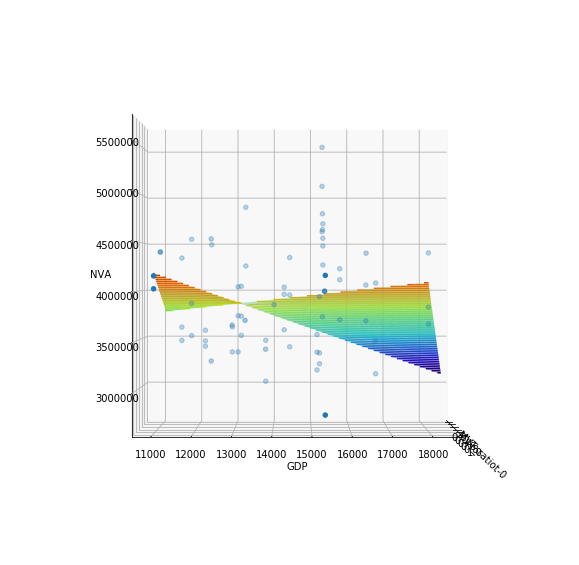

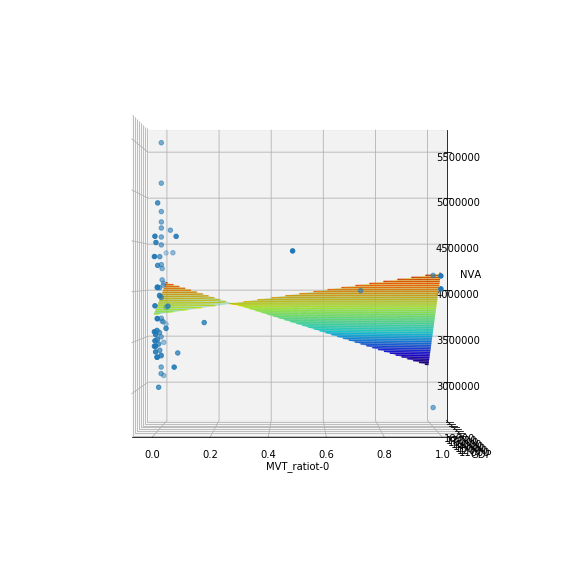

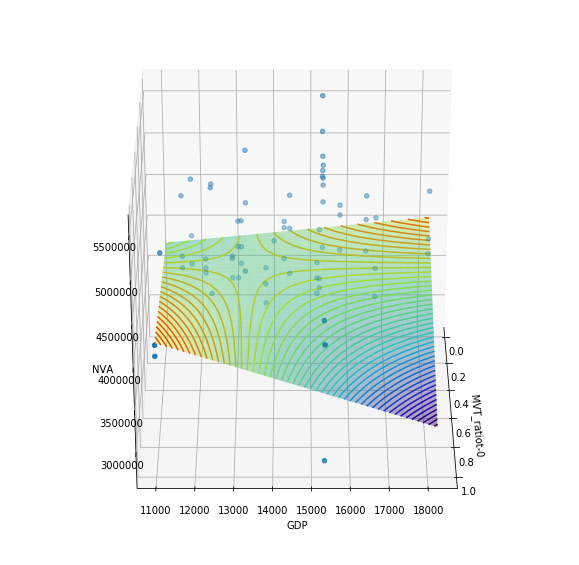

In [24]:
PlotXYZ(model_interactive,X_interactive,Y_interactive,0)
PlotXYZ(model_interactive,X_interactive,Y_interactive,270)
RotateXYZ(model_interactive,X_interactive,Y_interactive)

In [25]:
HTML("""
<div align="middle">
<video id="videoID" controls>
    <source src="animation.mp4" type="video/mp4" />
  </video>
</div>
""")

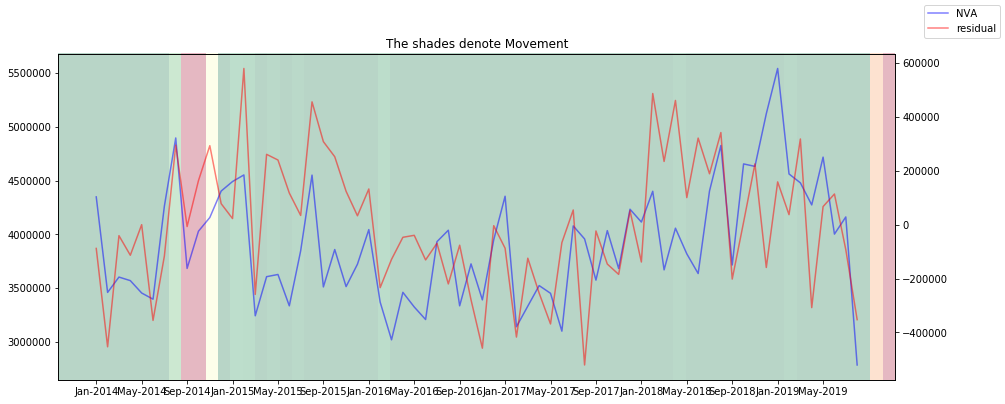

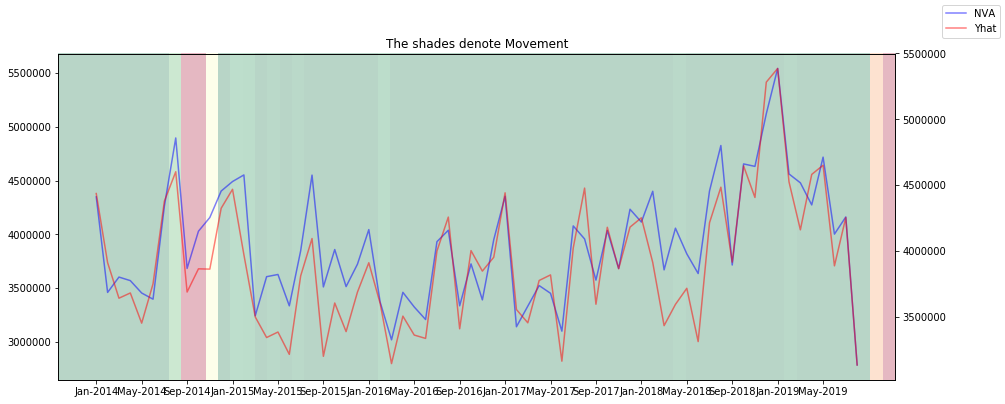

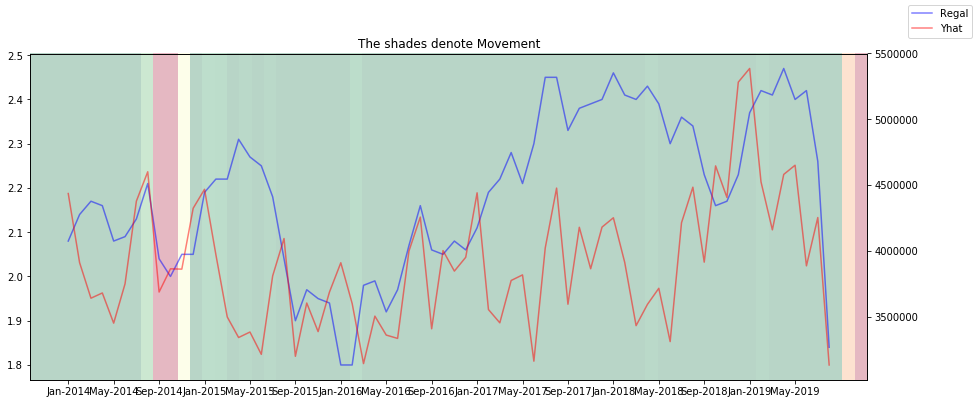

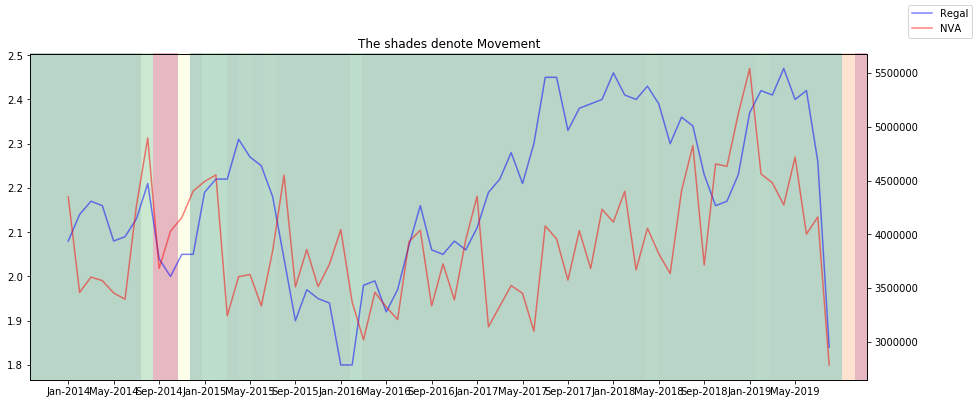

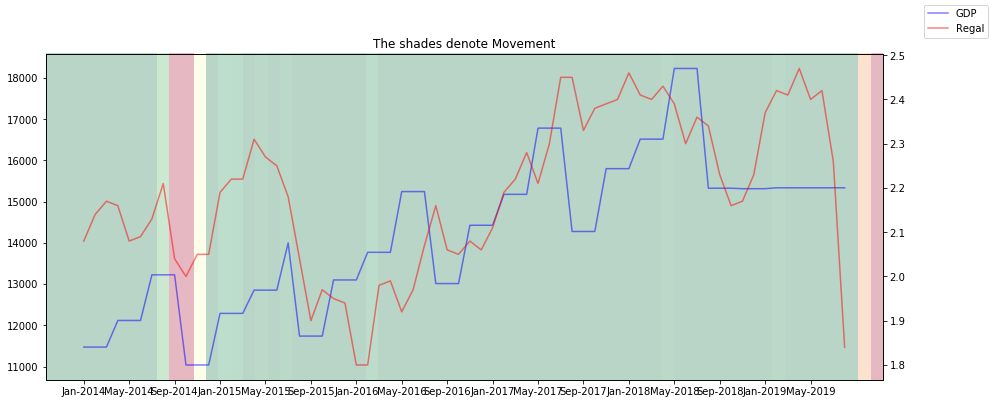

In [31]:
compare_trend(df,'Date',y_str,'residual',"MVT_ratiot-"+str(sft))
compare_trend(df,'Date',y_str,'Yhat',"MVT_ratiot-"+str(sft))
compare_trend(df,'Date',z_str,'Yhat',"MVT_ratiot-"+str(sft))
compare_trend(df,'Date',z_str,y_str,"MVT_ratiot-"+str(sft))
compare_trend(df,'Date','GDP',z_str,"MVT_ratiot-"+str(sft))

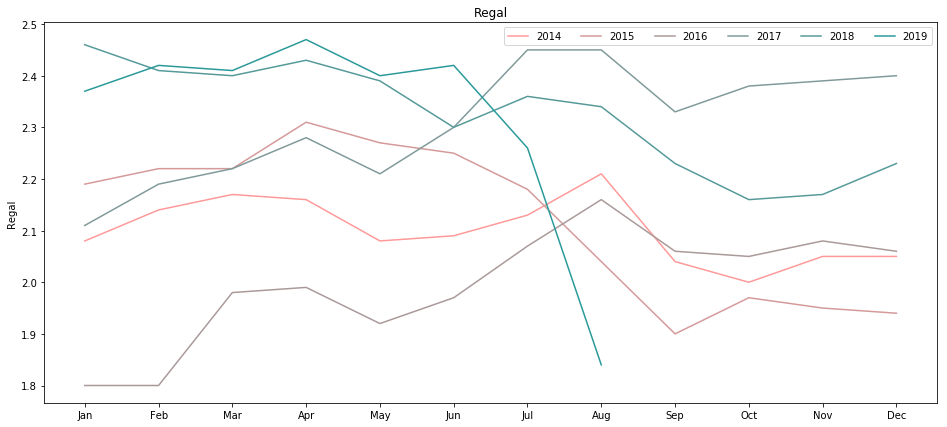

In [12]:
PlotSeasonality(2014,z_str)

                   GDP  MVT_ratiot-1         T        HD       HST
GDP           1.000000     -0.217749  0.809008 -0.188544  0.272433
MVT_ratiot-1 -0.217749      1.000000 -0.019239 -0.184891  0.125052
T             0.809008     -0.019239  1.000000 -0.116076  0.640741
HD           -0.188544     -0.184891 -0.116076  1.000000  0.007688
HST           0.272433      0.125052  0.640741  0.007688  1.000000


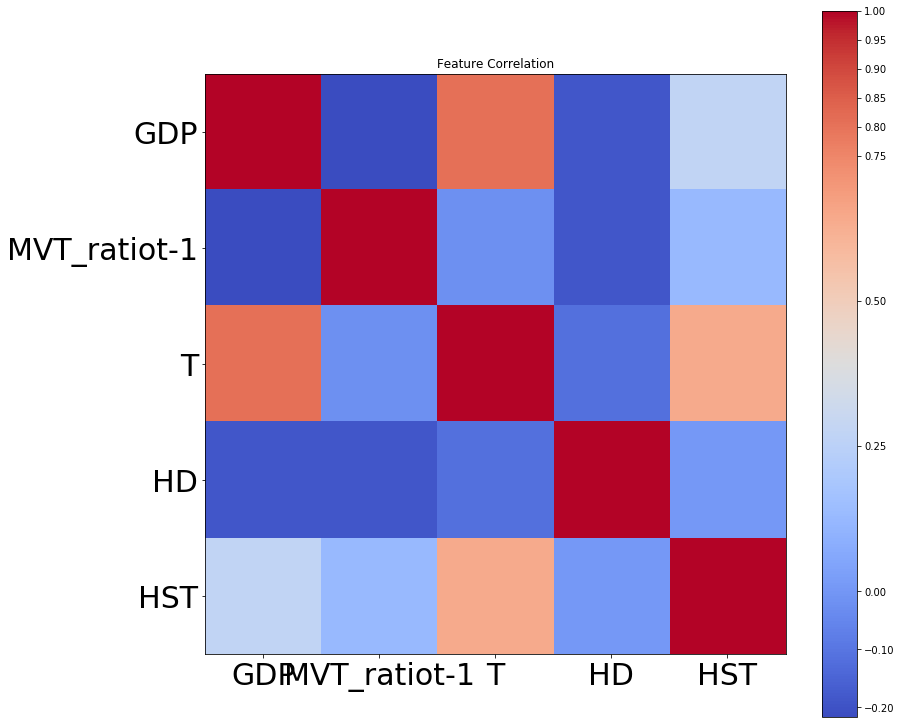

In [54]:
correlation_matrix(train[['GDP','MVT_ratiot-1','T','HD','HST']],30)

In [23]:
X_interactive = train[["MVT_ratiot-"+str(sft),"GDP","MVT_ratiot-"+str(sft)+'xGDP']]
Y_interactive = train[[y_str]]
model_interactive = sm.OLS(Y_interactive, sm.add_constant(X_interactive)).fit()
model_interactive.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    NVA   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.8521
Date:                Mon, 07 Oct 2019   Prob (F-statistic):              0.471
Time:                        20:48:37   Log-Likelihood:                -992.90
No. Observations:                  68   AIC:                             1994.
Df Residuals:                      64   BIC:                             2003.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              3.29e+06    5.7e+05      5.777      0.000    2.15e+06    4.43e+06
MVT_ratiot-0      2.418e+06    1.7e+06      1.419      0.161   -9.86e+05    5.82e+06
GDP                 43.6008     39.481      1.104      0.274     -35.272     122.474
MVT_ratiot-0xGDP  -181.8236    125.003     -1.455      0.151    -431.547      67.899
==============================================================================
Omnibus:                        3.606   Durbin-Watson:                   1.146
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                3.383
Skew:                           0.543   Prob(JB):                        0.184
Kurtosis:                       2.872   Cond. No.                     3.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""